In [8]:
import sunpy.map
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

from heliopy.data import psp
import heliopy.data.spice as spicedata
from heliopy.spice import Trajectory, furnish

import numpy as np
from datetime import datetime, timedelta

from helpers import streams, figdir
from pubtools import heliosphere as heliotools, solar as solartools

Load synoptic map
---

In [2]:
synop_map = sunpy.map.Map('data/aia193_synoptic_20181105.fits')

Load proton speed
---

In [11]:
starttime = datetime(2018, 10, 18)
endtime = starttime + timedelta(days=35)

psp_data = psp.merged_mag_plasma(starttime, endtime)
psp_data.data = psp_data.data.drop_duplicates().dropna()

Load SPICE kernels
---

In [12]:
kernels = spicedata.get_kernel('psp')
kernels += spicedata.get_kernel('psp_pred')
furnish(kernels)
psp_traj = Trajectory('SPP')

Generate trajectory
---

In [13]:
psp_traj.generate_positions(psp_data.index, 'Sun', 'IAU_SUN')

coords = psp_traj.coords
coords = SkyCoord(coords.lon, coords.lat, coords.radius,
                  obstime=synop_map.date,
                  observer=synop_map.observer_coordinate,
                  frame='heliographic_carrington')

Correct longitude for ballistic propagation
---

In [14]:
import importlib
importlib.reload(heliotools)
# Take a daily running average of vr
vr = psp_data.to_dataframe()['VR'].rolling(24, center=True, min_periods=1).mean().values * psp_data.quantity('VR').unit
# Project to source surface
ss_coords = heliotools.project_to_ss(coords, vr, 2.5 * const.R_sun)

In [9]:
synop_map_downsamp = synop_map.resample([1440, 720] * u.pix / 4)
contours = solartools.contour(synop_map_downsamp, 0.34)

Plot trajectory
---

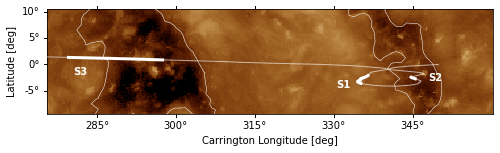

In [31]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection=synop_map)
synop_map.plot(norm=None, vmin=0.15)

ax.set_xlim(1100)
ax.set_ylim(320, 400)
for stream in streams:
    idxs = np.where((psp_data.index > stream.start) & (psp_data.index < stream.end))
    ax.plot_coord(ss_coords[idxs], color='white', lw=3)
ax.plot_coord(ss_coords, color='white', alpha=0.6, lw=1);
ax.text(1320, 340, 'S1', color='white', weight='bold')
ax.text(1390, 345, 'S2', color='white', weight='bold')
ax.text(1120, 350, 'S3', color='white', weight='bold')
ax.set_title('')
ax.grid()

for ctr in contours:
    if ctr.size > 100:
        ax.plot_coord(ctr, color='white', lw=0.5, linestyle='-')
fig.savefig(f'{figdir}/carrington.pdf', bbox_inches='tight')